# Setup

If you are using Google Colab to run this notebook and have the dataset stored in Google drive , uncomment and run the following cell to mounting Google Drive to Colab and follow the instructions.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

If you are using Google colab and have the dataset as a zip file in Google Drive,then : uncomment the following cell, provide filepath of the zip file( replace `zip_file_path` with the path) and run the cell.

In [ ]:
# !unzip 'zip_file_path'

In [2]:
# Limiting the fraction of GPU memory used

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import scipy

In [2]:
tf.__version__

'2.6.0'

# Loading and pre-processing the data

In [3]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

train_path = 'dataset/tomato/train'
valid_path = 'dataset/tomato/val'

In [4]:
# useful for getting number of output classes
folders = glob(train_path+'/*')

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [6]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10000 images belonging to 10 classes.


In [9]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 10 classes.


In [20]:
training_set.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [22]:
CLASS_NAMES=list(training_set.class_indices)
CLASS_NAMES

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [9]:
len(training_set.next())

2

In [10]:
(training_set.next()[0]).shape

(32, 224, 224, 3)

In [25]:
(training_set.next()[1]).shape

(32, 10)

Tomato___Septoria_leaf_spot


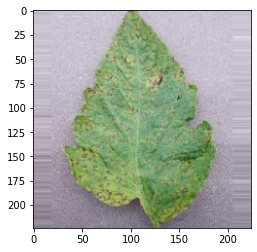

In [28]:
object=training_set.next()

plt.imshow(object[0][0])
print(CLASS_NAMES[np.argmax(object[1][0])])

In [12]:
# dataset=keras.preprocessing.image_dataset_from_directory(
#         train_path,
#                                                  image_size = (224, 224),
#                                                  batch_size = 32
#         )

Found 10000 files belonging to 10 classes.


In [15]:
# print(type(dataset))
# print(type(training_set))
# print(type(train_datagen))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'keras.preprocessing.image.DirectoryIterator'>
<class 'keras.preprocessing.image.ImageDataGenerator'>


In [14]:
# class_names=dataset.class_names
# class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Defining and Training the model

In [12]:
# Import the InceptionV3 model with the imagenet weights

inception = keras.applications.inception_v3.InceptionV3(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 0s 0us/step


In [18]:
# The shape of the input layer of the inception network=[None, 224, 224, 3] 
# The shape of our images =[224, 224, 3]
inception.input.shape

TensorShape([None, 224, 224, 3])

In [19]:
# Freeze the existing weights, as we will not train those weights
for layer in inception.layers:
    layer.trainable = False

In [20]:
# our layers
x = keras.layers.Flatten()(inception.output)
prediction = keras.layers.Dense(len(folders), activation='softmax')(x)

In [22]:
# create our model
model = keras.models.Model(inputs=inception.input, outputs=prediction)

## Summary of our model

In [23]:
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Visualizing our model

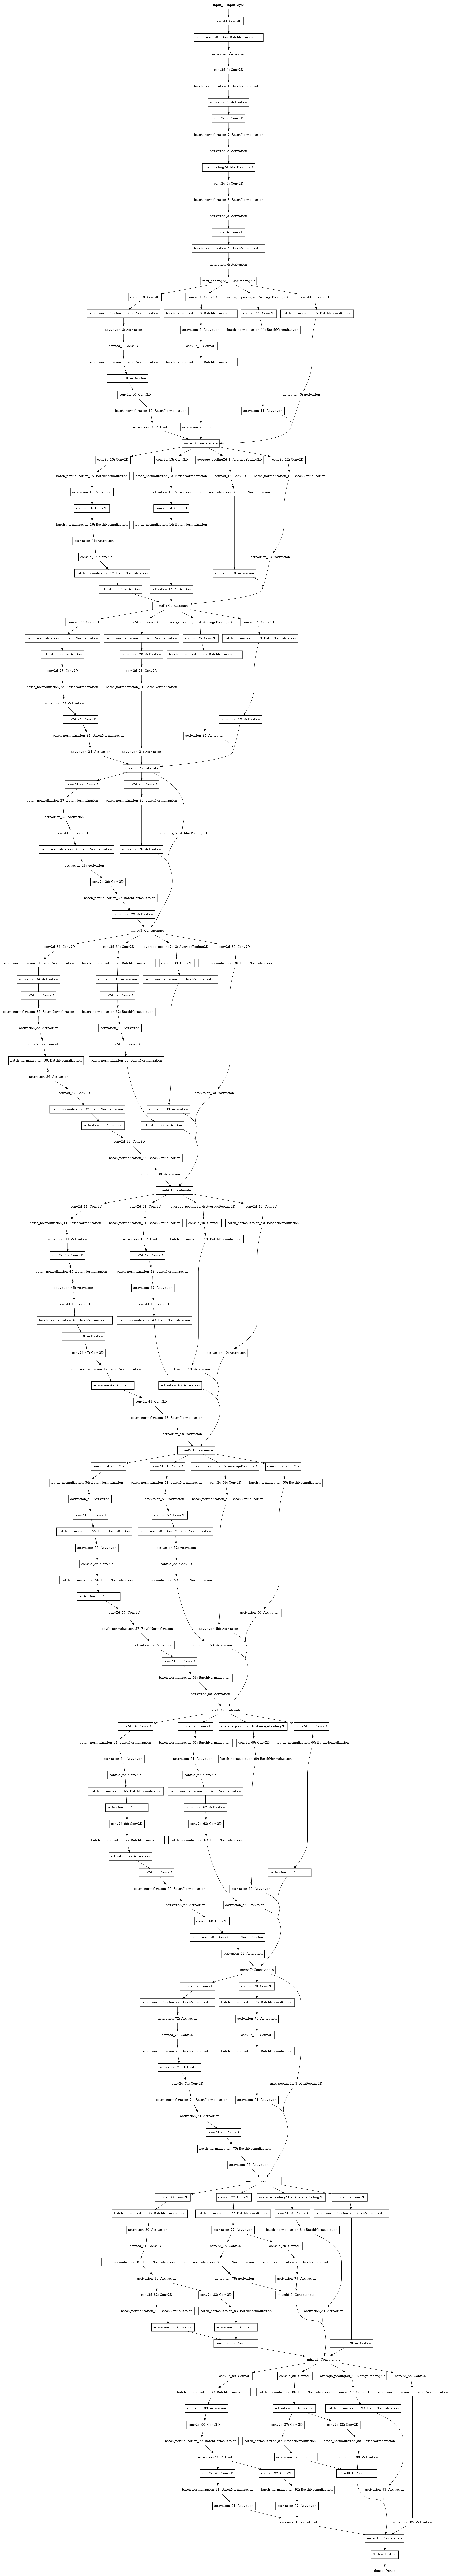

In [24]:
keras.utils.plot_model(model, "tomato_disease_model.png", show_shapes=False)

## Compiling, defining early stopping callback and fitting the model 

In [25]:
# Specify the cost, optimization method and metrics to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(1e-3),
  metrics=['accuracy']
)

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [27]:
# fit the model
history = model.fit(
      training_set,
      validation_data=test_set,
      epochs=100,
      callbacks=[early_stopping]    
)

Epoch 1/100
313/313 [==============================] - 223s 680ms/step - loss: 6.2914 - accuracy: 0.5328 - val_loss: 2.3699 - val_accuracy: 0.7060
Epoch 2/100
313/313 [==============================] - 125s 398ms/step - loss: 1.9841 - accuracy: 0.7630 - val_loss: 3.4693 - val_accuracy: 0.7030
Epoch 3/100
313/313 [==============================] - 122s 391ms/step - loss: 2.1588 - accuracy: 0.7949 - val_loss: 2.6427 - val_accuracy: 0.7760
Epoch 4/100
313/313 [==============================] - 123s 394ms/step - loss: 1.8497 - accuracy: 0.8218 - val_loss: 4.4260 - val_accuracy: 0.7320
Epoch 5/100
313/313 [==============================] - 122s 389ms/step - loss: 1.7571 - accuracy: 0.8382 - val_loss: 3.5606 - val_accuracy: 0.7510
Epoch 6/100
313/313 [==============================] - 122s 389ms/step - loss: 1.4831 - accuracy: 0.8595 - val_loss: 3.2913 - val_accuracy: 0.7770
Epoch 7/100
313/313 [==============================] - 122s 389ms/step - loss: 1.6764 - accuracy: 0.8582 - val_loss: 3

## Save the model to .h5 file

In [28]:
model.save('tomato_disease_classification_model_inception.h5')

# Plots and Predictions

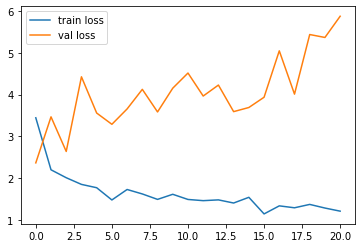

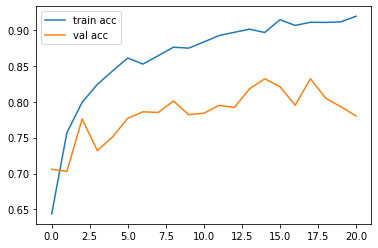

<Figure size 432x288 with 0 Axes>

In [29]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('train_and_validation_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('train_and_validation__accuracy')